In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, recall_score,roc_auc_score


# Setting Up for Model Ensambling

In [2]:

df = pd.read_csv("fraud_reduced.csv", index_col=0)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.33, stratify=y)

In [3]:
import joblib

knn_clf = joblib.load("Models\KNN.pkl")
xgb_clf = joblib.load("Models\XGBModel.pkl")
rnd_clf = joblib.load("Models\RandomForest.pkl")
ext_clf = joblib.load("Models\Extra_trees.pkl")

knn_scaled = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', knn_clf)
])

ext_balance = ImbPipeline([
    ('smt', SMOTE(sampling_strategy=0.5)),
    ('ext', ext_clf)
])

In [4]:
estimator_list =[
    ('xgb', xgb_clf),
    ('rnd', rnd_clf),
    ('knn', knn_scaled),
    ('ext', ext_balance),
]

### Evaluating Performance Metrics for Base Models

In [ ]:
y_true = y_test.copy()
y_xgb = xgb_clf.predict(X_test)
y_rnd = rnd_clf.predict(X_test)
y_knn = knn_clf.predict(X_test)
y_ext = ext_clf.predict(X_test)

In [21]:
models = ['XBoost', 'Random Forest', 'KNN', 'Extra Trees']
metrics = ['F1 Score', 'Recall','ROC AUC']
results = {'Model': models}
for metric in metrics:
    metric_scores = []
    for y_pred in [ y_xgb,y_rnd,y_knn,y_ext]:
        if metric == 'F1 Score':
            score = f1_score(y_true, y_pred)
        elif metric == 'Recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'ROC AUC':
            score = roc_auc_score(y_true, y_pred)
        metric_scores.append(score)
    results[metric] = metric_scores

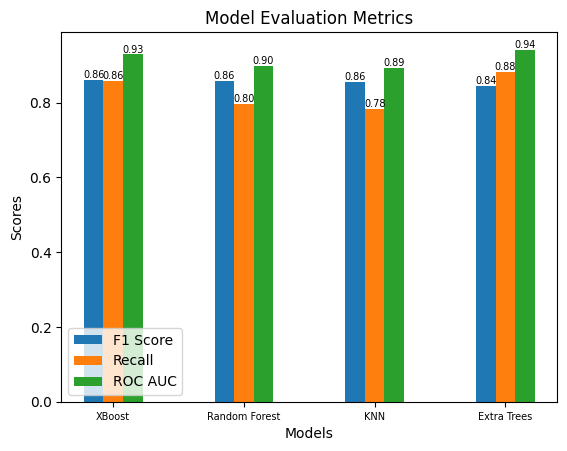

In [22]:
import matplotlib.pyplot as plt

x = range(len(models))
bar_width = 0.15

for i, metric in enumerate(metrics):
    plt.bar([pos + i * bar_width for pos in x], results[metric], bar_width, label=metric)
    # Add text labels to the bars
    for j, score in enumerate(results[metric]):
        plt.text(x[j] + i * bar_width, score, f'{score:.2f}', ha='center', va='bottom', fontsize=7)

plt.xlabel('Models', fontsize=10)
plt.ylabel('Scores')
plt.xticks([pos + bar_width for pos in x], models, fontsize=7)
plt.legend(loc='lower left')
plt.title('Model Evaluation Metrics')
plt.show()

# Running Ensamble Models

In [37]:
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)
stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              random_state=None, ...)),
                               ('rnd',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=102,
                                                       n_jobs=-1)),
                               ('knn',
                                Pipeline(steps=[('scaler', RobustScaler()),
                                                ('svm',
                                                 KNeighborsClassifier(n_jobs=-1))])),
                               ('ext',
                                Pipeline(steps=[('smt',
                                                 SMOTE(sampling_strategy=0.5)),
                                                ('ext',
                                                 ExtraTreesClassifier(max_depth=19,
                                                                      n_estimators=156,
                                                                      n_jobs=-1))]))],
                   final_estimator=LogisticRegression())

In [6]:
voting_classifier_hard = VotingClassifier(estimators=estimator_list, voting='hard')
voting_classifier_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            n_estimators=147, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('rnd',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=102,
                                                     n_jobs=-1)),
                             ('knn',
                              Pipeline(steps=[('scaler', RobustScaler()),
                                              ('svm',
                                               KNeighborsClassifier(n_jobs=-1))])),
                             ('ext',
                              Pipeline(steps=[('smt',
                                               SMOTE(sampling_strategy=0.5)),
                                              ('ext',
                                               ExtraTreesClassifier(max_depth=19,
                                                                    n_estimators=156,
                                                                    n_jobs=-1))]))])

In [23]:
voting_classifier_soft = VotingClassifier(estimators=estimator_list, voting='soft')
voting_classifier_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            random_state=None, ...)),
                             ('rnd',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=102,
                                                     n_jobs=-1)),
                             ('knn',
                              Pipeline(steps=[('scaler', RobustScaler()),
                                              ('svm',
                                               KNeighborsClassifier(n_jobs=-1))])),
                             ('ext',
                              Pipeline(steps=[('smt',
                                               SMOTE(sampling_strategy=0.5)),
                                              ('ext',
                                               ExtraTreesClassifier(max_depth=19,
                                                                    n_estimators=156,
                                                                    n_jobs=-1))]))],
                 voting='soft', weights=[2, 1, 1, 2])

In [38]:
y_true = y_test.copy()
y_stack = stack_model.predict(X_test)
y_hard = voting_classifier_hard.predict(X_test)
y_soft = voting_classifier_soft.predict(X_test)


In [39]:
models = ['Stacked', 'Vot Hard', 'Vot Soft']
metrics = ['F1 Score', 'Recall','ROC AUC']
results = {'Model': models}
for metric in metrics:
    metric_scores = []
    for y_pred in [ y_stack,y_hard,y_soft]:
        if metric == 'F1 Score':
            score = f1_score(y_true, y_pred)
        elif metric == 'Recall':
            score = recall_score(y_true, y_pred)
        elif metric == 'ROC AUC':
            score = roc_auc_score(y_true, y_pred)
        metric_scores.append(score)
    results[metric] = metric_scores

## Evaluating Performance Metrics for Ensambled Models

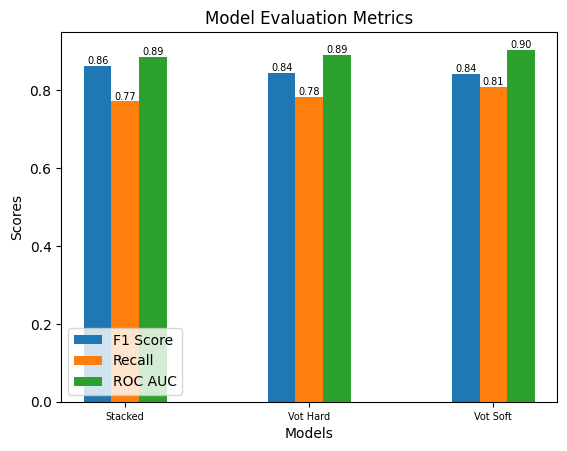

In [40]:
import matplotlib.pyplot as plt

x = range(len(models))
bar_width = 0.15

for i, metric in enumerate(metrics):
    plt.bar([pos + i * bar_width for pos in x], results[metric], bar_width, label=metric)
    # Add text labels to the bars
    for j, score in enumerate(results[metric]):
        plt.text(x[j] + i * bar_width, score, f'{score:.2f}', ha='center', va='bottom', fontsize=7)

plt.xlabel('Models', fontsize=10)
plt.ylabel('Scores')
plt.xticks([pos + bar_width for pos in x], models, fontsize=7)
plt.legend(loc='lower left')
plt.title('Model Evaluation Metrics')
plt.show()

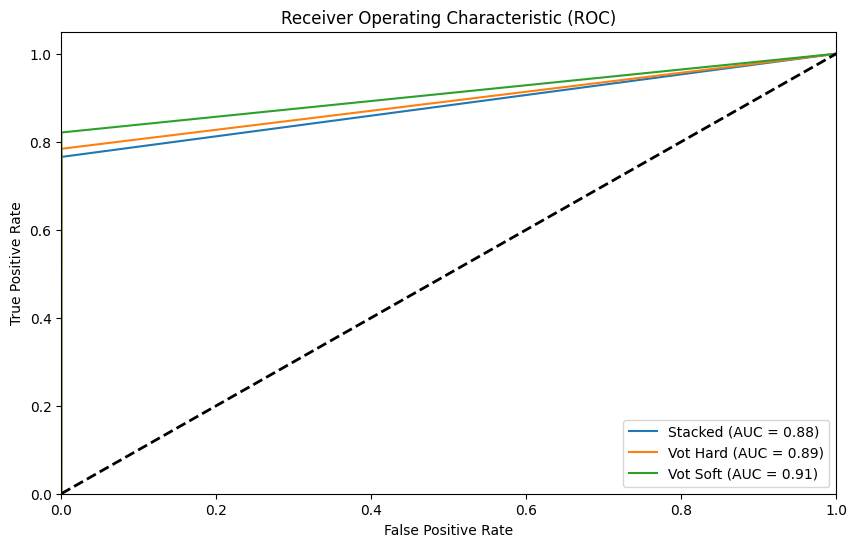

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models = ['Stacked', 'Vot Hard', 'Vot Soft']
results = {'Model': models}

# Assuming you have data for 6 models
data = [y_stack, y_hard, y_soft]

plt.figure(figsize=(10, 6))

for i, model_name in enumerate(models):
    fpr, tpr, _ = roc_curve(y_true, data[i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 

# Hyperparameter Adjunst for Improved Model Performance

- ## Soft Voting Classifier

In [24]:
voting_classifier_soft_tuned = VotingClassifier(estimators=estimator_list, voting='soft', weights=[2,1,1,2])
voting_classifier_soft_tuned.fit(X_train, y_train)
y_soft_tun = voting_classifier_soft_tuned.predict(X_test)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            random_state=None, ...)),
                             ('rnd',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=102,
                                                     n_jobs=-1)),
                             ('knn',
                              Pipeline(steps=[('scaler', RobustScaler()),
                                              ('svm',
                                               KNeighborsClassifier(n_jobs=-1))])),
                             ('ext',
                              Pipeline(steps=[('smt',
                                               SMOTE(sampling_strategy=0.5)),
                                              ('ext',
                                               ExtraTreesClassifier(max_depth=19,
                                                                    n_estimators=156,
                                                                    n_jobs=-1))]))],
                 voting='soft', weights=[2, 1, 1, 2])

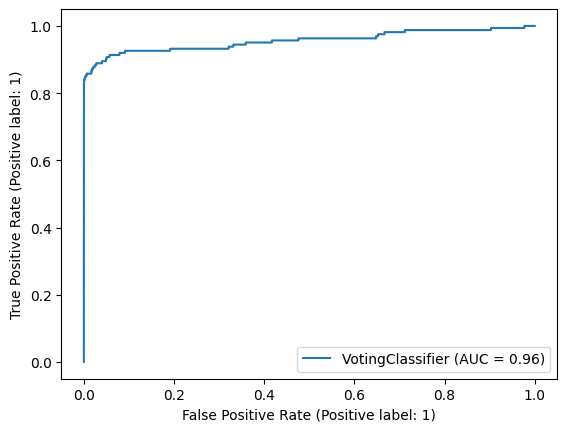

In [26]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(voting_classifier_soft_tuned, X_test, y_test)

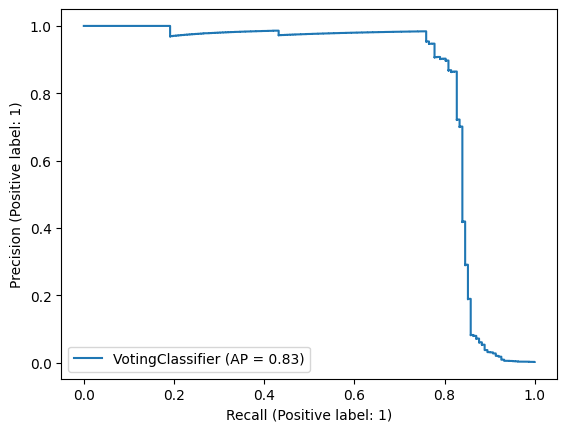

In [27]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(voting_classifier_soft_tuned, X_test, y_test)

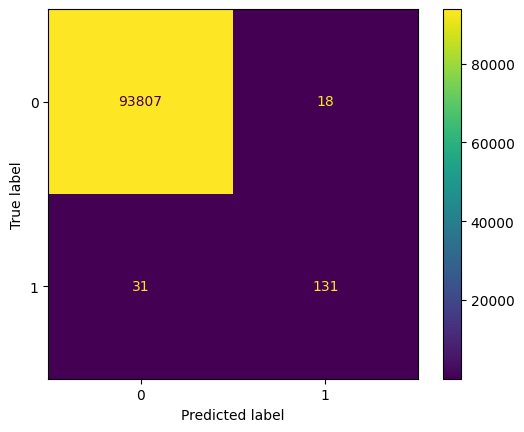

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(voting_classifier_soft_tuned, X_test, y_test)

- ## Stacked Classifier

In [46]:
stack_model_tun = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression(class_weight={0: 0.30, 1: 0.2, 2 : 0.15, 3 : 0.35})
)
stack_model_tun.fit(X_train, y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=102,
                                                       n_jobs=-1)),
                               ('knn',
                                Pipeline(steps=[('scaler', RobustScaler()),
                                                ('svm',
                                                 KNeighborsClassifier(n_jobs=-1))])),
                               ('ext',
                                Pipeline(steps=[('smt',
                                                 SMOTE(sampling_strategy=0.5)),
                                                ('ext',
                                                 ExtraTreesClassifier(max_depth=19,
                                                                      n_estimators=156,
                                                                      n_jobs=-1))]))],
                   final_estimator=LogisticRegression(class_weight={0: 0.3,
                                                                    1: 0.2,
                                                                    2: 0.15,
                                                                    3: 0.35}))

In [ ]:
y_stack_tun = stack_model_tun.predict(X_test)

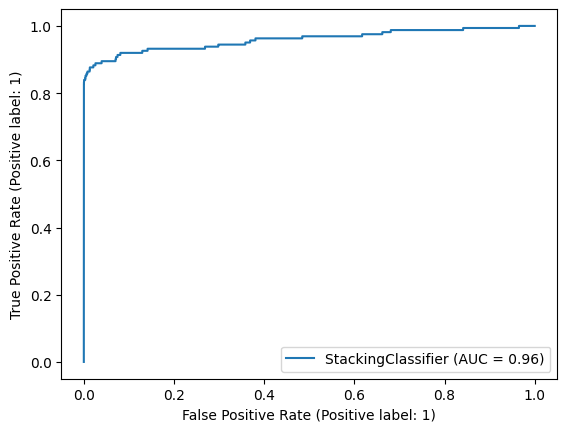

In [33]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(stack_model_tun, X_test, y_test)

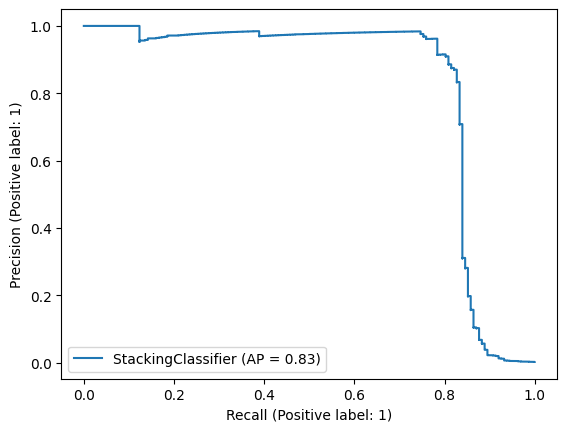

In [34]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(stack_model_tun, X_test, y_test)

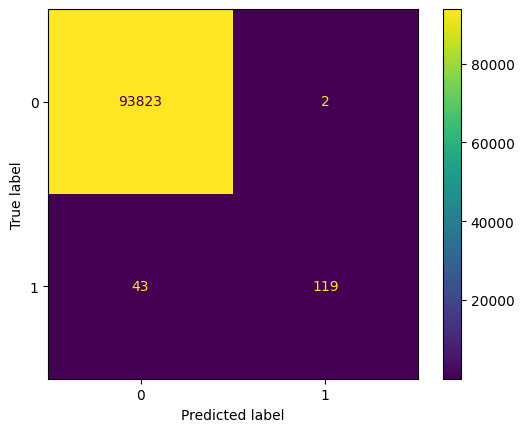

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(stack_model_tun, X_test, y_test)